In [67]:
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [69]:
def normalize(text):
    """
    Normalize text by removing non-alphanumeric chars and lowercasing.
    """
    return re.sub(r'\W+', '', text).lower()


def parse_bib_titles(bib_path):
    """
    Naively parse a .bib file to extract titles.
    """
    titles = []
    with open(bib_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    # Split entries by '@'
    entries = text.split('@')[1:]
    for entry in entries:
        for line in entry.splitlines():
            if line.strip().lower().startswith('title'):
                parts = line.split('=', 1)
                if len(parts) == 2:
                    val = parts[1].strip().rstrip(',').strip()
                    # Remove enclosing braces
                    if val.startswith('{') and val.endswith('}'):
                        val = val[1:-1]
                    titles.append(val)
                break
    return titles

In [70]:
class Args:
    def __init__(self):
        self.dataset_path = "dataset_papers"
args = Args()
dataset_dir = args.dataset_path

# Build title -> folder mapping
title_map = {}
print("Indexing paper titles...")
for folder in tqdm(os.listdir(dataset_dir)):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        title_file = os.path.join(folder_path, 'title.txt')
        if os.path.isfile(title_file):
            with open(title_file, 'r', encoding='utf-8', errors='ignore') as f:
                title = f.read().strip()
            norm = normalize(title)
            title_map[norm] = folder

Indexing paper titles...


  0%|          | 0/6545 [00:00<?, ?it/s]

100%|██████████| 6545/6545 [00:02<00:00, 2451.57it/s]


In [71]:
# Initialize directed graph
G = nx.DiGraph()
G.add_nodes_from(title_map.values())

# Parse bibliographies and add edges
print("Parsing bibliographies and adding edges...")
for folder in tqdm(title_map.values(), desc="Processing papers"):
    folder_path = os.path.join(dataset_dir, folder)
    # Look for .bib file
    bib_files = [f for f in os.listdir(folder_path) if f.endswith('.bib')]
    if bib_files:
        bib_path = os.path.join(folder_path, bib_files[0])
        cited_titles = parse_bib_titles(bib_path)
    else:
        cited_titles = []

    for cited in cited_titles:
        norm = normalize(cited)
        if norm in title_map:
            G.add_edge(folder, title_map[norm])

Parsing bibliographies and adding edges...


Processing papers:   0%|          | 0/6545 [00:00<?, ?it/s]

Processing papers: 100%|██████████| 6545/6545 [00:56<00:00, 116.49it/s] 


In [72]:
dataset_dir = os.path.join("dataset_papers")
dataset = os.listdir(dataset_dir)

In [78]:
def get_docs(folders):
    papers, docs = [], []
    for folder in folders:
        fp = os.path.join(dataset_dir, folder)
        tfile = os.path.join(fp, "title.txt")
        afile = os.path.join(fp, "abstract.txt")
        if os.path.isdir(fp) and os.path.isfile(tfile) and os.path.isfile(afile):
            with open(tfile, 'r', encoding='utf-8', errors='ignore') as f:
                t = f.read().strip()
            with open(afile, 'r', encoding='utf-8', errors='ignore') as f:
                a = f.read().strip()
            papers.append(folder)
            docs.append(t + " " + a)
    return papers, docs

In [83]:
def func(K):
    overall = []
    for i in range(10):
        train, test = train_test_split(dataset, test_size=0.2)
        
        papers, docs = get_docs(train)

        vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
        tfidf_mat = vectorizer.fit_transform(docs)

        test_docs = get_docs(test)[1]
        test_vec = vectorizer.transform(test_docs)
        
        sims = cosine_similarity(test_vec, tfidf_mat)
        
        # K = 5
        result = [[papers[i] for i in sim.argsort()[::-1][:K]] for sim in sims]
        
        recall = 0
        cnt = 0
        for pred, t in zip(result, test):
            true = set(G.successors(t))
            if len(true):
                recall += len(set(pred).intersection(true)) / len(true)
                cnt += 1
        
        overall.append(recall / cnt)
    return sum(overall) / len(overall)

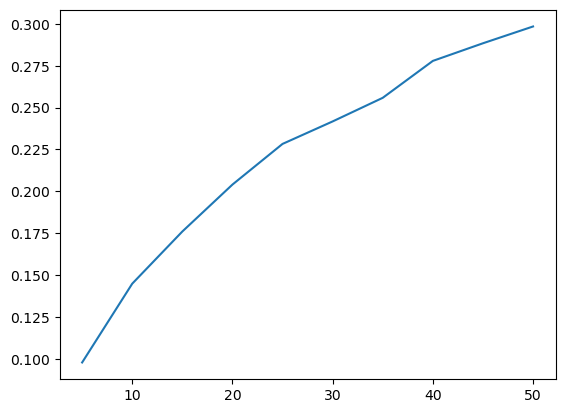

In [88]:
x = list(range(5, 55, 5))
plt.plot(x, [func(k) for k in x])
plt.show()